# Machine Learning Pipeline - Model Training - Logistic Regression

En este notebook, recogemos los conjuntos de datos transformados y las variables seleccionadas que guardamos en los notebooks anteriores

# Reproducibilidad: sembramos la semilla

Con el objetivo de garantizar la reproducibilidad entre ejecuciones del mismo notebook, pero también entre el entorno de investigación y producción, para cada paso que incluya algún elemento de aleatoriedad, es extremadamente importante que **establezcamos la semilla**

In [1]:
# Para manipulacion de datos
import pandas as pd
import numpy as np

# Para graficar
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold
from mlxtend.plotting import plot_decision_regions

# Para guardar el modelo
import joblib

# Para construir los modelos
from sklearn.linear_model import LogisticRegression

# Para evaluar los modelos
from sklearn.metrics import roc_auc_score, classification_report

# Para visualizar todas las columnas del dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# cargar el conjunto de entrenamiento y el de prueba con las variables diseñadas 
# construimos y guardamos estos conjuntos de datos en el notebook anterior. 

X_train = pd.read_csv('../data/xtrain.csv')
X_test = pd.read_csv('../data/xtest.csv')


In [3]:
# Cargamos la target

y_train = pd.read_csv('../data/ytrain.csv')
y_test = pd.read_csv('../data/ytest.csv')


### Instanciamos el modelo de regresion logistica: 

Recuerdamos sembrar la semilla.

In [112]:
# configurar el modelo 
# recuerdar establecer random_state / seed

# Instancia

rl = LogisticRegression(penalty='l1', solver='saga')

# Entrenamos el modelo

rl.fit(X_train, y_train.values.ravel())

LogisticRegression(penalty='l1', solver='saga')

In [113]:
# evalua el modelomos: 

pred = rl.predict_proba(X_train)[:,1]


print('train auc: {}'.format(
    roc_auc_score(y_train, pred)))
print()

# make predictions for test set
pred = rl.predict_proba(X_test)[:,1]

# determine auc

print('test auc: {}'.format(
    roc_auc_score(y_test, pred)))
print()

rl_auc={'Auc':np.round(roc_auc_score(y_test, pred),2)}

train auc: 0.847749403867769

test auc: 0.8527125474695807



In [67]:
# Importante: Vamos a tomar la prediccion y no las probabilidades

pred=rl.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



**Importante**:

Aqui hay que tener en cuenta, que las predicciones son hechas en base a un criterio estandar y bajo la suposicion de que las clases estan balanceadas. Por lo tanto, el criterio de decision para la clasificacion que utiliza el algoritmo es 50,50. Recordemos que nuestro modelo tiene una tasa de 27% y por lo tanto deberiamos reveer el criterio que el algoritmo utiliza para clasificar los ceros y los unos. De no Hacerlo, estariamos ordenando al modelo a que clasifique un hipotetico cliente como futuro abandono con un score minimo del 50% cuando la tasa media de anbandono es 27%.


**Interpretacion**

- Precision: de los abandonos que el modelo predice, el 68% son abandonos reales
- Recall: de los abandonos reales, el modelo esta encontrando el 53% o sea la mitad
- f1 (media armonica entre precision y recall): 

Mas sobre Precision y Recall:
Definamos A = {Conjuntos de unos reales} y B = {Conjunto de unos que el modelo predice}
Consideremos (A intersecado con B) = {Conjunto de unos reales que el modelo tambien predice}
Ahora bien, esa cantidad puede ser interpretada relativo al total en A o al total en B. Luego:
- Precision: |A intersec B|/|B| 
- Recall: |A intersec B|/|A|
Visto de esta manera podemos inferir algunas cuestiones:
    - Tanto recall como precision, estan entre 0 y 1 (los cardinales de la interseccion siempre son menores que la de los conjuntos intersecados (+).
    - |A| esta fijo y sujeto a los datos de entrenamiento.
    - |B| depende del umbral de corte (es decir, aquel score a partir del cual el modelo considera que hay un 1):
        - Mientras mas abandonos sea capaz de predecir el modelo (no necesariamente los reales) recall tendra una tendencia en aumento, pues la interseccion de A con B se asemejara cada vez mas a A. Luego Recall tendera a 1.
        - Por otro lado, Precision tendera a disminuir pues el |B| aumenta siempre en mayor proporcion que |A interserc B|

Vamos a pasar a confeccionar una tabla de umbrales con distintos cortes para poder evaluar el funcionamiento del modelo

In [54]:
X_test.head()

,gender_0,gender_1,SeniorCitizen_0,SeniorCitizen_1,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,tenure_disc_corr_0,tenure_disc_corr_1,tenure_disc_corr_2,tenure_disc_corr_3,TotalCharges_disc_corr_0,TotalCharges_disc_corr_1,TotalCharges_disc_corr_2,TotalCharges_disc_corr_3
0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
2,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
3,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
4,1,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1


Generamos la tabla de scores obtenidos del modelo

In [68]:
# Utilizamos predict_proba porque nos interesa la probabilidad

pred_modelo=pd.DataFrame(data=rl.predict_proba(X_test)[:,1], columns=["Pred"],index=None)
pred_modelo.head()

,Pred
0,0.011743
1,0.405545
2,0.839365
3,0.200180
4,0.038027


In [102]:
def verifica(valor,umbral):
    if valor<0:
        return 0
    elif valor>=0:
        return 1
    
def tab_umbrales(df):
    df=df.copy()
    
    for p in range(20,40,1):
        
        df[p]=df["Pred"]-(p/100)
        
        df["pred_adj_"+str(p/100)]=df[p].apply(lambda x: verifica(x,p/100))
        
        df.drop(columns=[p],inplace=True)
    return df

In [107]:
umbrales=tab_umbrales(pred_modelo)
umbrales.head(10)

,Pred,pred_adj_0.2,pred_adj_0.21,pred_adj_0.22,pred_adj_0.23,pred_adj_0.24,pred_adj_0.25,pred_adj_0.26,pred_adj_0.27,pred_adj_0.28,pred_adj_0.29,pred_adj_0.3,pred_adj_0.31,pred_adj_0.32,pred_adj_0.33,pred_adj_0.34,pred_adj_0.35,pred_adj_0.36,pred_adj_0.37,pred_adj_0.38,pred_adj_0.39
0,0.011743,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.405545,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0.839365,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0.200180,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.038027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.398718,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0.691909,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,0.207924,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.748423,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,0.615226,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [104]:
lista=list(umbrales.drop(columns="Pred"))
lista

['pred_adj_0.2',
 'pred_adj_0.21',
 'pred_adj_0.22',
 'pred_adj_0.23',
 'pred_adj_0.24',
 'pred_adj_0.25',
 'pred_adj_0.26',
 'pred_adj_0.27',
 'pred_adj_0.28',
 'pred_adj_0.29',
 'pred_adj_0.3',
 'pred_adj_0.31',
 'pred_adj_0.32',
 'pred_adj_0.33',
 'pred_adj_0.34',
 'pred_adj_0.35',
 'pred_adj_0.36',
 'pred_adj_0.37',
 'pred_adj_0.38',
 'pred_adj_0.39']

In [109]:
for var in lista:
    
    tab=pd.crosstab(umbrales[var],y_test["Churn"])
    total=tab[0][0]+tab[1][0]+tab[0][1]+tab[1][1]
    
    # Identificamos
    
    tp=tab[1][1]
    tn=tab[0][0]
    fp=tab[0][1]
    fn=tab[1][0]
    
    # metricas
    
    accuracy=(tn+tp)/total
    precision=tp/(fp+tp)
    recall=tp/(tp+fn)
    f1=2*(precision*recall)/(precision+recall)   
    
    # Impresion
    
    print()
    print(tab)
    print()
    print("accuracy .........", np.round(accuracy,2))
    print("Precision ........", np.round(precision,2))
    print("Recall ...........", np.round(recall,2))
    print("f1 ...............", np.round(f1,2))
    print()
    print("-----------------------\n")
    
    


Churn           0    1
pred_adj_0.2          
0             694   50
1             341  324

accuracy ......... 0.72
Precision ........ 0.49
Recall ........... 0.87
f1 ............... 0.62

-----------------------


Churn            0    1
pred_adj_0.21          
0              705   54
1              330  320

accuracy ......... 0.73
Precision ........ 0.49
Recall ........... 0.86
f1 ............... 0.63

-----------------------


Churn            0    1
pred_adj_0.22          
0              715   58
1              320  316

accuracy ......... 0.73
Precision ........ 0.5
Recall ........... 0.84
f1 ............... 0.63

-----------------------


Churn            0    1
pred_adj_0.23          
0              725   64
1              310  310

accuracy ......... 0.73
Precision ........ 0.5
Recall ........... 0.83
f1 ............... 0.62

-----------------------


Churn            0    1
pred_adj_0.24          
0              731   65
1              304  309

accuracy ......... 0.74
Prec

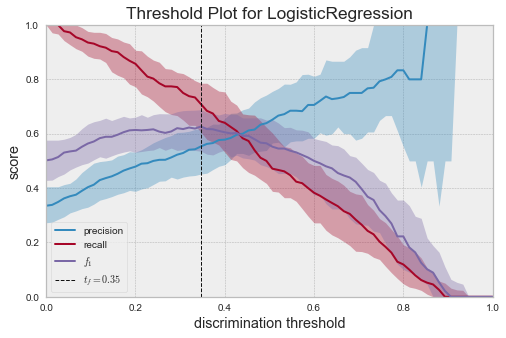

In [114]:
# Grafico de umbrales

# Parametros para el grafico
style.use('bmh') or plt.style.use('bmh')
fig, ax=plt.subplots(figsize=(8,5))

# Llamamos a la funcion que grafica
discrimination_threshold(rl,X_test,y_test,exclude='queue_rate',ax=ax);


In [73]:
y_test.reset_index(drop=True)

,Churn
0,0
1,0
2,1
3,1
4,0
...,...
1404,0
1405,0
1406,0
1407,0


In [74]:
# evaluemos la distribución de los errores: 

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(rl.predict(X_test))

preds

0       0
1       0
2       1
3       0
4       0
       ..
1404    0
1405    0
1406    0
1407    0
1408    1
Length: 1409, dtype: int64

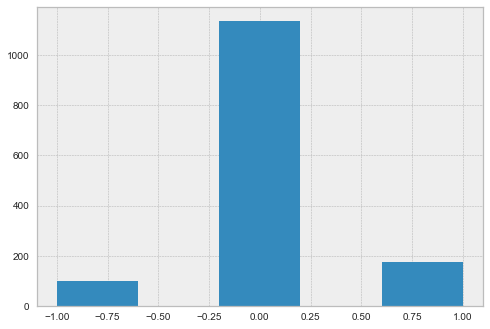

In [115]:
# evaluemos la distribución de los errores: 
# Deben distribuirse con bastante normalidad

errors = y_test['Churn'] - preds
errors.hist(bins=5,density=False)
plt.show()

In [80]:
rl.coef_.ravel()

array([ 0.04140136, -0.04174888, -0.10521422,  0.1048667 ,  0.00989075,
       -0.01023827,  0.06601151, -0.06635903,  0.05064425, -0.05099177,
       -0.18668783,  0.13569606,  0.05064425, -0.12768949, -0.40160589,
        0.52894785,  0.26789452, -0.14055255, -0.12768949,  0.14458568,
       -0.01724371, -0.12768949,  0.05208825,  0.07525372, -0.12768949,
        0.21426668, -0.08692471, -0.12768949, -0.08743751,  0.21477948,
       -0.12768949, -0.08837271,  0.21571468, -0.12768949,  0.82039994,
        0.00188337, -0.82263084, -0.17886566,  0.17851813, -0.03515807,
       -0.12409412, -0.09333826,  0.25224293,  0.54279079,  0.07295447,
       -0.09231853, -0.52377426,  0.65520866,  0.01900555, -0.25370032,
       -0.42086141])

# Graficos

### Importancia de las variables (Feature importance)

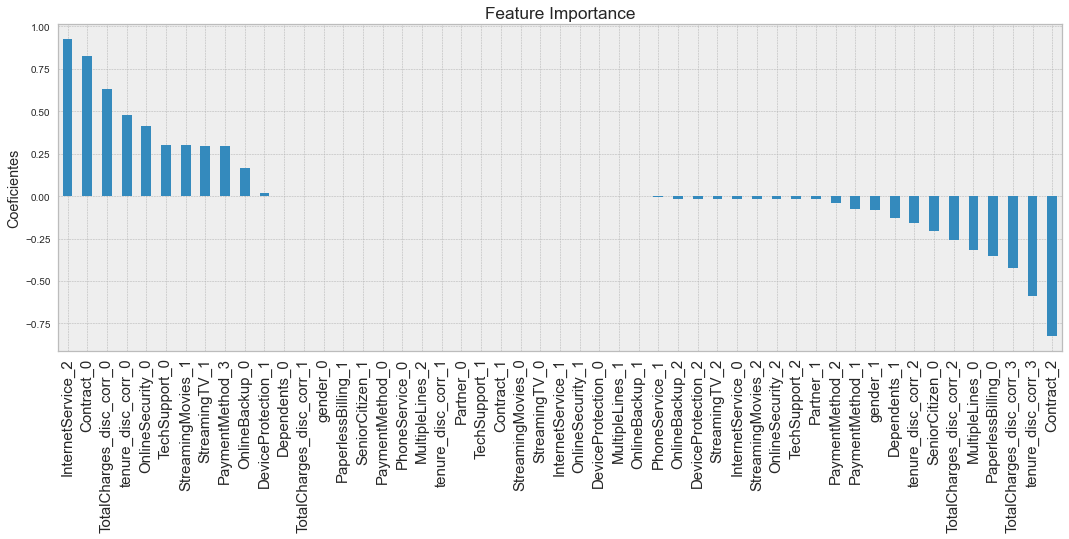

In [116]:
# Finalmente, solo por diversión, veamos la importancia de las variables
style.use('bmh') or plt.style.use('bmh')

importance = pd.Series(rl.coef_.ravel())
importance.index = rl.feature_names_in_
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.xticks(size=15)
plt.ylabel('Coeficientes')
plt.title('Feature Importance');

### Gain Chart

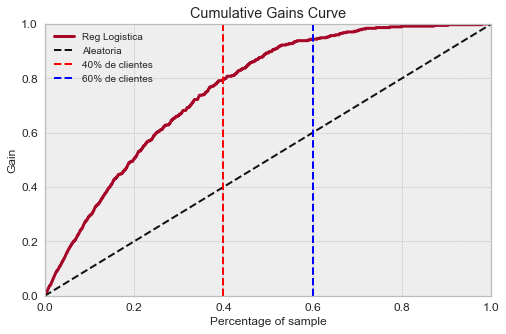

In [117]:
# Parametros de grafico
style.use('bmh') or plt.style.use('bmh')
fig, ax=plt.subplots(figsize=(8,5))

# Instanciamos al grafico
skplt.metrics.plot_cumulative_gain(y_test,rl.predict_proba(X_test),ax=ax)
del ax.lines[0]

# Agregamos Lineas indicadoras
ax.axvline(
    x            =0.4,
    c            ='red',
    linestyle    ='--',
    label        ='40% de clientes'
)

ax.axvline(
    x            =0.6,
    c            ='blue',
    linestyle    ='--',
    label        ='60% de clientes'
)

# Modificamos la legenda
plt.legend(labels=['Reg Logistica', 'Aleatoria','40% de clientes','60% de clientes']);

## Guardamos la metrica

In [18]:
pd.DataFrame(rl_auc,index=['Reg_Log']).to_csv('../data/performance_algoritmos.csv',index=False)

In [19]:
# Generamos el dataframe con clientes y el score arrojado para cada uno

clean_data_with_dummies=pd.read_csv('../data/clean_data_with_dummies.csv')


In [20]:
clean_data_with_dummies.head()

,gender_0,gender_1,SeniorCitizen_0,SeniorCitizen_1,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,tenure_disc_corr_0,tenure_disc_corr_1,tenure_disc_corr_2,tenure_disc_corr_3,TotalCharges_disc_corr_0,TotalCharges_disc_corr_1,TotalCharges_disc_corr_2,TotalCharges_disc_corr_3
0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
3,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0


In [21]:
pred=pd.DataFrame(rl.predict_proba(clean_data_with_dummies)[:,1])
data_predicciones=pd.concat([clean_data_with_dummies,pred],axis=1)
data_predicciones.rename(columns={0:"pred"},inplace=True)

In [22]:
data_predicciones.head()

,gender_0,gender_1,SeniorCitizen_0,SeniorCitizen_1,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,tenure_disc_corr_0,tenure_disc_corr_1,tenure_disc_corr_2,tenure_disc_corr_3,TotalCharges_disc_corr_0,TotalCharges_disc_corr_1,TotalCharges_disc_corr_2,TotalCharges_disc_corr_3,pred
0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0.590886
1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.034780
2,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0.312515
3,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0.038149
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0.757895


In [23]:
data_predicciones.to_csv('../data/data_predicciones.csv', index=False)

# Regresion Logistica con statsmodels

In [24]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [25]:
# División de los datos en train y test
# ==============================================================================
# X = datos[['matematicas']]
# y = datos['matricula']

# X_train, X_test, y_train, y_test = train_test_split(
#                                         X.values.reshape(-1,1),
#                                         y.values.reshape(-1,1),
#                                         train_size   = 0.8,
#                                         random_state = 1234,
#                                         shuffle      = True
#                                     )

In [27]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

         Current function value: 0.413494
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
# Intervalos de confianza para los coeficientes del modelo
# ==============================================================================
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci = pd.DataFrame(intervalos_ci)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci

In [ ]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo.predict(exog = X_train)
predicciones[:4]

In [ ]:
# Clasificación predicha
# ==============================================================================
clasificacion = np.where(predicciones<0.5, 0, 1)
clasificacion

In [ ]:
# Predicciones en todo el rango de X
# ==============================================================================
# Se crea un vector con nuevos valores interpolados en el rango de observaciones.
grid_X = np.linspace(
            start = min(datos.matematicas),
            stop  = max(datos.matematicas),
            num   = 200
         ).reshape(-1,1)

grid_X = sm.add_constant(grid_X, prepend=True)
predicciones = modelo.predict(exog = grid_X)

In [ ]:
# Accuracy de test del modelo 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")

# Regularizacion

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 3)

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression(normalize=True)
modelo.fit(X = X_train, y = y_train)

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

In [ ]:
# Error de test del modelo 
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")

# Ridge

In [ ]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()


In [ ]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [ ]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

In [ ]:
# Error de test del modelo 
# ==============================================================================
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")

# Lasso

In [ ]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

In [ ]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

In [ ]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [ ]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

In [ ]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

In [ ]:
# Mejor modelo alpha óptimo + 1sd
# ==============================================================================
modelo = Lasso(alpha=optimo_1sd, normalize=True)
modelo.fit(X_train, y_train)

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

In [ ]:
# Error de test del modelo 
# ==============================================================================
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")

# Elastic Net

In [ ]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

In [ ]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

In [ ]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');


In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

In [ ]:
# Error de test del modelo 
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")

# Comparacion

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

# Informacion de sesion

In [ ]:
from sinfo import sinfo
sinfo()